In [1]:
from platform import python_version
import os 
import pandas as pd
import numpy as np
import cv2 as cv2
import albumentations 
from fastai.vision.all import *
from utils_gastrunet import *


print(python_version())
import torch
print( torch.cuda.is_available())
print( torch.cuda.get_device_name(0) )
print(torch.__version__)
import fastai
print(fastai.__version__)

3.8.16
True
NVIDIA GeForce GTX 1070
1.10.1+cu102
2.7.12


In [2]:
path = Path('./example1/')

path_img = path/'images'
path_anno = path/'labels'

fnames = get_image_files(path_img)
anno_names = get_image_files(path_anno)

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

4
['background' 'organoid']


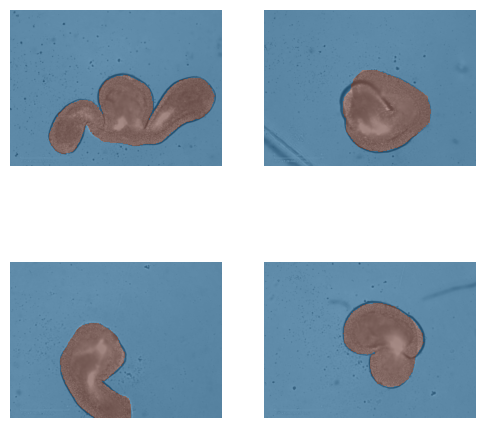

In [4]:
path = Path('./example1/')

files = get_image_files(path/'images')
print(len(files))

codes = np.loadtxt(path/'codes.txt', dtype='str')
print(codes)


def labeller(x):
    return path/f'labels/{x.stem}{x.suffix}'


db = DataBlock(blocks=(ImageBlock(cls=PILImageBW), MaskBlock(codes=codes)),
               splitter=RandomSplitter(valid_pct=0.2, seed=42),
               item_tfms=[Resize((378,512))],
               get_items=get_image_files,
               get_y=labeller,batch_tfms=[Resize((378,512)), Normalize.from_stats(*imagenet_stats)])

dls = db.dataloaders(source=path_img, bs=4, drop_last=True)

dls.show_batch()



In [5]:
dls.vocab = codes

name2id = {v:k for k,v in enumerate(codes)}

void_code = name2id['background']

def acc_semseg(inp, targ): #from https://walkwithfastai.com/Segmentation
  targ = targ.squeeze(1)
  mask = targ != void_code
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [6]:
opt = ranger
learn = unet_learner(dls, arch=resnet34, metrics=acc_semseg, self_attention=True, act_cls=Mish, opt_func=opt)

learn.summary()
#learn.fine_tune(6)



DynamicUnet (Input shape: 4 x 3 x 378 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 189 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 95 x 128   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [7]:
path = Path('./example_GFP/')

path_img = path/'images'

fnames = get_image_files(path_img)


In [8]:

for i in fnames:
    #img = cv2.imread(str(i), cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(str(i), cv2.IMREAD_COLOR)
    #plt.imshow(img)
    resized = cv2.resize(img, (512,378), interpolation = cv2.INTER_AREA)
    #plt.imshow(resized)
    cv2.imwrite(filename= str(i) , img=resized)
    

4


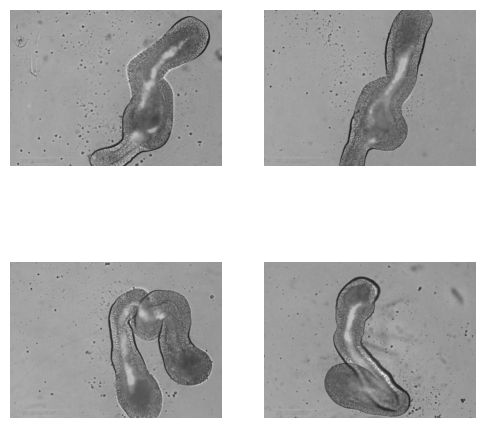

In [9]:

files = fnames
#files = [ i for i in files if 'ctr' in str(i)] #if just a group of data is wanted

print(len(files))

test_dl = learn.dls.test_dl(fnames[:4])

test_dl.show_batch()


In [10]:
if not os.path.isdir(path/f'masks'):
    os.mkdir(path/f'masks')

In [11]:
df=[]
chunk_size=1

for i in range(0, len(files), chunk_size):
    
    print(i)
    chunk=files[i:i+chunk_size]
    
    learn.load('GFP_ORGANOID_model_1')
    test_dl = learn.dls.test_dl(chunk)
    preds = learn.get_preds(dl=test_dl)

    learn.load('GFP_model_1')
    test_dl = learn.dls.test_dl(chunk)
    preds2 = learn.get_preds(dl=test_dl)

    for p in range(len(preds[0])):
        print(chunk[p])
        pt1 = pred_tensor(path, chunk[p], preds[0][p], preds2[0][p]  )
        df.append(pt1)
              

0


example_GFP\images\T101_Jenh191_A_disp_A11_1_2023y08m30d_16h09m.tif
1


example_GFP\images\T101_Jenh191_A_disp_A5_1_2023y08m30d_16h09m.tif
2


example_GFP\images\T101_Jenh191_A_disp_A9_1_2023y08m30d_16h09m.tif
3


example_GFP\images\T101_Jenh191_B_disp_G10_1_2023y08m30d_16h17m.tif


In [12]:
Data = pd.DataFrame(df, columns=('Image','px_ON', 'px_ON_perc', "area", "perimeter", "policomplex", "centroid","bounding_box", 
                                 "aspect_ratio", "convex_area","solidity","eccentricity",
                                 "max_length",'fiber_orientation','fiber_curvature',
                                'px_ON_gfp', 'px_ON_perc_gfp', 'px_ON_perc_gfp_organoid', 'areas_gfp')) 

output_table="./table_exampleGFP.csv"
Data.to_csv(output_table, index=False)
Data

,Image,px_ON,px_ON_perc,area,perimeter,policomplex,centroid,bounding_box,aspect_ratio,convex_area,solidity,eccentricity,max_length,fiber_orientation,fiber_curvature,px_ON_gfp,px_ON_perc_gfp,px_ON_perc_gfp_organoid,areas_gfp
0,example_GFP\images\T101_Jenh191_A_disp_A11_1_2023y08m30d_16h09m.tif,38773,27.135998,38286.5,1136.271203,0.029678,"(347.0755314101141, 200.70894005284717)","(192, 19, 287, 359)",0.799443,52547.5,0.728607,0.925404,[461.08535316173834 pix],[0.66821162819303 rad],[0.7909172943156617 rad],1939,1.357045,5.0,"[117.0, 155.5, 79.5, 1229.5, 103.5]"
1,example_GFP\images\T101_Jenh191_A_disp_A5_1_2023y08m30d_16h09m.tif,37406,26.179278,36923.5,1083.536140,0.029345,"(300.3127005836391, 197.8631585124198)","(182, 0, 224, 378)",0.592593,44941.0,0.821599,0.960003,[470.70057685088807 pix],[0.47718857624980376 rad],[0.6214822745147146 rad],1868,1.307354,5.0,"[63.5, 520.0, 1094.5]"
2,example_GFP\images\T101_Jenh191_A_disp_A9_1_2023y08m30d_16h09m.tif,47195,33.030290,46579.5,1415.526033,0.030389,"(345.16097210146097, 209.9386174890957)","(240, 65, 248, 313)",0.792332,59071.0,0.788534,0.601365,[608.1269837220809 pix],[-0.3522786137900206 rad],[0.609746104173156 rad],1890,1.322751,4.0,"[553.5, 245.0, 150.5, 249.5, 485.5]"
3,example_GFP\images\T101_Jenh191_B_disp_G10_1_2023y08m30d_16h17m.tif,34018,23.808124,33582.5,1021.016370,0.030403,"(233.03042259113127, 236.0151765552495)","(147, 43, 204, 335)",0.608955,46886.0,0.716259,0.845573,[408.9604614807105 pix],[-0.0013749732620591097 rad],[0.8483112724346589 rad],1007,0.704768,3.0,"[31.5, 94.5, 47.0, 694.5]"


# Analyses

In [13]:
import re
import seaborn as sns


output_table="./table_exampleGFP.csv"

Data = pd.read_csv(output_table)

Data['well_id']=[str(x).split(sep='_')[8] for x in Data.Image]
Data['image']=[str(x).split(sep='\\')[-1] for x in Data.Image]
Data['plate_num']=[str(x).split(sep='_')[6] for x in Data.Image]

# in T101 117pix  == 400um
max_lens = [float( re.search(r'\d+\.\d', str(x) ).group() )*(400/117000) if re.search(r'\d+\.\d', str(x) ) else np.nan  for x in Data.max_length]
Data['max_length_mm']= max_lens

Data['curvature'] = [float( re.search(r'\b\d+\.\d+\b', str(x)).group() ) for x in Data.fiber_curvature]

Data


,Image,px_ON,px_ON_perc,area,perimeter,policomplex,centroid,bounding_box,aspect_ratio,convex_area,...,fiber_curvature,px_ON_gfp,px_ON_perc_gfp,px_ON_perc_gfp_organoid,areas_gfp,well_id,image,plate_num,max_length_mm,curvature
0,example_GFP\images\T101_Jenh191_A_disp_A11_1_2023y08m30d_16h09m.tif,38773,27.135998,38286.5,1136.271203,0.029678,"(347.0755314101141, 200.70894005284717)","(192, 19, 287, 359)",0.799443,52547.5,...,[0.79091729] rad,1939,1.357045,5.0,"[117.0, 155.5, 79.5, 1229.5, 103.5]",16h09m.tif,T101_Jenh191_A_disp_A11_1_2023y08m30d_16h09m.tif,1,1.576068,0.790917
1,example_GFP\images\T101_Jenh191_A_disp_A5_1_2023y08m30d_16h09m.tif,37406,26.179278,36923.5,1083.536140,0.029345,"(300.3127005836391, 197.8631585124198)","(182, 0, 224, 378)",0.592593,44941.0,...,[0.62148227] rad,1868,1.307354,5.0,"[63.5, 520.0, 1094.5]",16h09m.tif,T101_Jenh191_A_disp_A5_1_2023y08m30d_16h09m.tif,1,1.609231,0.621482
2,example_GFP\images\T101_Jenh191_A_disp_A9_1_2023y08m30d_16h09m.tif,47195,33.030290,46579.5,1415.526033,0.030389,"(345.16097210146097, 209.9386174890957)","(240, 65, 248, 313)",0.792332,59071.0,...,[0.6097461] rad,1890,1.322751,4.0,"[553.5, 245.0, 150.5, 249.5, 485.5]",16h09m.tif,T101_Jenh191_A_disp_A9_1_2023y08m30d_16h09m.tif,1,2.078974,0.609746
3,example_GFP\images\T101_Jenh191_B_disp_G10_1_2023y08m30d_16h17m.tif,34018,23.808124,33582.5,1021.016370,0.030403,"(233.03042259113127, 236.0151765552495)","(147, 43, 204, 335)",0.608955,46886.0,...,[0.84831127] rad,1007,0.704768,3.0,"[31.5, 94.5, 47.0, 694.5]",16h17m.tif,T101_Jenh191_B_disp_G10_1_2023y08m30d_16h17m.tif,1,1.397949,0.848311


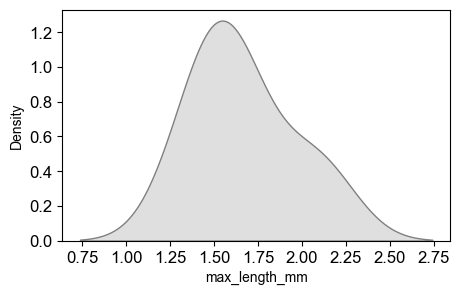

In [14]:
plt.figure(figsize=(5,3))
ax = sns.kdeplot(Data['max_length_mm'], fill=True, color='grey')
ax= plt.xticks(rotation=0)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
sns.set_style("whitegrid",{"axes.edgecolor": "grey","grid.color": "grey"})
sns.set_style("whitegrid", {'grid.color': 'grey','grid.linestyle': '--',"axes.edgecolor": "grey"})
plt.show()

In [15]:
numeric_columns = Data.select_dtypes(include='number')
numeric_columns.corr()

,px_ON,px_ON_perc,area,perimeter,policomplex,aspect_ratio,convex_area,solidity,eccentricity,px_ON_gfp,px_ON_perc_gfp,px_ON_perc_gfp_organoid,max_length_mm,curvature
px_ON,1.000000,1.000000,0.999999,0.994094,0.266156,0.717740,0.900670,0.424551,-0.803880,0.628652,0.628652,0.174880,0.988852,-0.692629
px_ON_perc,1.000000,1.000000,0.999999,0.994094,0.266156,0.717740,0.900670,0.424551,-0.803880,0.628652,0.628652,0.174880,0.988852,-0.692629
area,0.999999,0.999999,1.000000,0.994050,0.265785,0.718585,0.900998,0.423937,-0.803491,0.629173,0.629173,0.175518,0.988671,-0.692129
perimeter,0.994094,0.994094,0.994050,1.000000,0.369180,0.714436,0.922934,0.358931,-0.862159,0.542817,0.542817,0.069390,0.982594,-0.639016
policomplex,0.266156,0.266156,0.265785,0.369180,1.000000,0.208063,0.489120,-0.456264,-0.772136,-0.559837,-0.559837,-0.878635,0.257616,0.262506
aspect_ratio,0.717740,0.717740,0.718585,0.714436,0.208063,1.000000,0.894002,-0.183434,-0.492634,0.569450,0.569450,0.261383,0.606063,-0.104280
convex_area,0.900670,0.900670,0.900998,0.922934,0.489120,0.894002,1.000000,-0.009980,-0.826428,0.437008,0.437008,-0.014186,0.837194,-0.310993
solidity,0.424551,0.424551,0.423937,0.358931,-0.456264,-0.183434,-0.009980,1.000000,-0.092557,0.582678,0.582678,0.490395,0.525347,-0.947067
eccentricity,-0.803880,-0.803880,-0.803491,-0.862159,-0.772136,-0.492634,-0.826428,-0.092557,1.000000,-0.042853,-0.042853,0.445033,-0.811786,0.363430
px_ON_gfp,0.628652,0.628652,0.629173,0.542817,-0.559837,0.569450,0.437008,0.582678,-0.042853,1.000000,1.000000,0.875478,0.597881,-0.680680
